In [8]:
import ast
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
# Compute Dice & IoU per annotated polygon region
def load_manual_annotations(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    if df.empty:
        raise RuntimeError(f"{csv_path} is empty or missing!")
    return df

def rasterize_polygon(shape_attrs: dict, img_shape: tuple) -> np.ndarray:
    """Given VIA polygon attrs and image (h, w), return binary mask."""
    # shape_attrs must have name=='polygon'
    if shape_attrs.get("name") != "polygon":
        return None
    xs = shape_attrs["all_points_x"]
    ys = shape_attrs["all_points_y"]
    pts = np.vstack((xs, ys)).T.astype(np.int32)
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 1)
    return mask.astype(bool)

def compute_region_metrics(gt_mask: np.ndarray, pr_mask: np.ndarray):
    """Return dice, iou, gt_area, pr_area."""
    gt = gt_mask.astype(bool)
    pr = pr_mask.astype(bool)
    inter = np.logical_and(gt, pr).sum()
    union = np.logical_or(gt, pr).sum()
    dice = 2 * inter / (gt.sum() + pr.sum()) if (gt.sum() + pr.sum()) > 0 else np.nan
    iou  = inter / union         if union > 0          else np.nan
    return dice, iou, int(gt.sum()), int(pr.sum())

In [6]:
# --- Configuration ---
CSV_PATH = Path("Df_created_from_images/manual_annotation.csv")
CAM_CONFIG = {
    "cam0": {
        "img_dir":  Path("data/Experiment_6/exp6_cam0/exp6_cam0_cropped_small_14d"),
        "pred_dir": Path("masks/cam0_masks")
    },
    "cam1": {
        "img_dir":  Path("data/Experiment_6/exp6_cam1/exp6_cam1_cropped_14d"),
        "pred_dir": Path("masks/cam1_masks")
    }
}

OUT_DIR = Path("Df_created_from_images")
OUT_DIR.mkdir(exist_ok=True)

In [7]:
df_via = load_manual_annotations(CSV_PATH)
results = []

for _, row in df_via.iterrows():
    filename = row["filename"]
    cam       = filename.split("_", 1)[0]
    cfg       = CAM_CONFIG.get(cam)
    if cfg is None:
        continue

    shape_attrs = ast.literal_eval(row["region_shape_attributes"])
    reg_attrs   = ast.literal_eval(row.get("region_attributes", "{}"))
    # load image
    img_path = cfg["img_dir"] / filename
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    # rasterize GT
    gt_mask = rasterize_polygon(shape_attrs, img.shape)
    if gt_mask is None:
        continue

    # load prediction
    stem = Path(filename).stem
    pred_files = list(cfg["pred_dir"].glob(f"*{stem}*mask.png"))
    if not pred_files:
        continue
    pr_mask = cv2.imread(str(pred_files[0]), cv2.IMREAD_GRAYSCALE)
    if pr_mask is None:
        continue
    pr_mask = pr_mask > 0

    # compute metrics
    dice, iou, gt_area, pr_area = compute_region_metrics(gt_mask, pr_mask)

    results.append({
        "camera":     cam,
        "filename":   filename,
        "region_id":  reg_attrs.get("id", ""),
        "dice":       dice,
        "iou":        iou,
        "gt_area_px": gt_area,
        "pr_area_px": pr_area
    })

# build DataFrame
df_res = pd.DataFrame(results)
print(df_res)
print("\nMean metrics by camera:")
print(df_res.groupby("camera")[["dice","iou"]].mean())

# save for posterity
df_res.to_csv(OUT_DIR / "segmentation_comparison.csv", index=False)


   camera              filename region_id      dice       iou  gt_area_px  \
0    cam0  cam0_05-08_02-00.jpg            0.653003  0.484784      310340   
1    cam0  cam0_05-08_10-00.jpg            0.692526  0.529667      345848   
2    cam0  cam0_05-09_07-00.jpg            0.690178  0.526925      311667   
3    cam0  cam0_05-11_02-00.jpg            0.684248  0.520044      667003   
4    cam0  cam0_05-14_17-00.jpg            0.701241  0.539931     1034046   
5    cam1  cam1_05-09_12-00.jpg            0.666824  0.500177      745556   
6    cam1  cam1_05-09_12-00.jpg            0.085573  0.044699       46305   
7    cam1  cam1_05-11_05-00.jpg            0.841640  0.726578     2538506   
8    cam1  cam1_05-11_18-00.jpg            0.787801  0.649894     3610984   
9    cam1  cam1_05-14_00-00.jpg            0.807698  0.677428     4825328   
10   cam1  cam1_05-12_00-00.jpg            0.857971  0.751268     3713650   

    pr_area_px  
0       330092  
1       392617  
2       348809  
3      

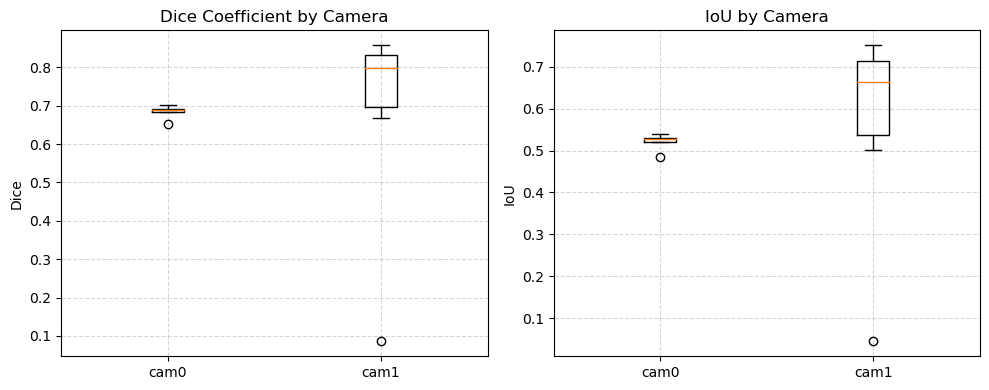

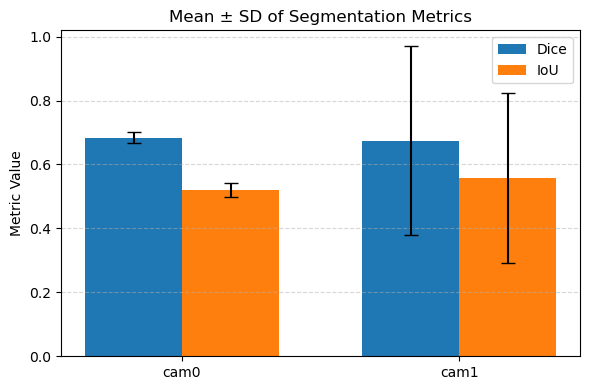

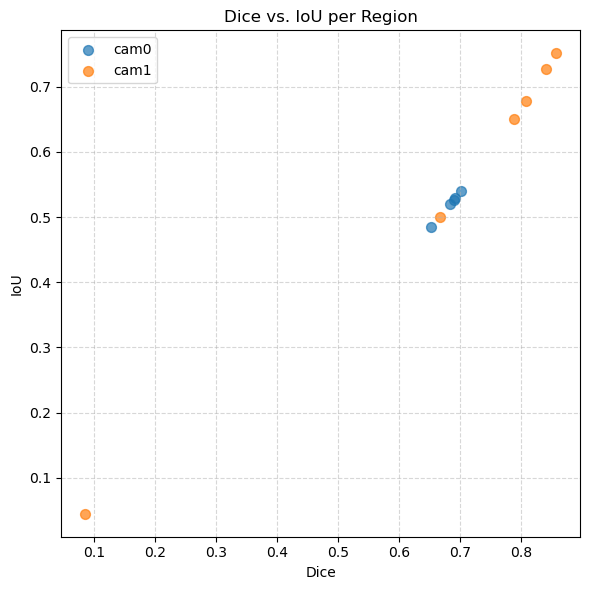

In [9]:
# ─────────────────────────── Cell 2 ───────────────────────────
# Visualize segmentation metrics (Dice & IoU)


# ensure df_res exists
if 'df_res' not in locals() or df_res.empty:
    raise RuntimeError("df_res is missing or empty! Run Cell 1 first.")

grouped = df_res.groupby("camera")
cams     = list(grouped.groups.keys())

# 1) Boxplots: Dice | IoU by camera
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# Dice
dice_data = [grouped.get_group(c)["dice"].dropna().values for c in cams]
axes[0].boxplot(dice_data, labels=cams)
axes[0].set_title("Dice Coefficient by Camera")
axes[0].set_ylabel("Dice")
axes[0].grid(True, linestyle='--', alpha=0.5)

# IoU
iou_data = [grouped.get_group(c)["iou"].dropna().values for c in cams]
axes[1].boxplot(iou_data, labels=cams)
axes[1].set_title("IoU by Camera")
axes[1].set_ylabel("IoU")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 2) Bar chart: mean ± std
means = grouped[["dice","iou"]].mean()
stds  = grouped[["dice","iou"]].std()
x     = np.arange(len(cams))
w     = 0.35

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - w/2, means["dice"], width=w, yerr=stds["dice"], capsize=5, label="Dice")
ax.bar(x + w/2, means["iou"],  width=w, yerr=stds["iou"],  capsize=5, label="IoU")

ax.set_xticks(x)
ax.set_xticklabels(cams)
ax.set_ylabel("Metric Value")
ax.set_title("Mean ± SD of Segmentation Metrics")
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 3) Scatter: Dice vs IoU per region
colors = {"cam0": "tab:blue", "cam1": "tab:orange"}

fig, ax = plt.subplots(figsize=(6,6))
for cam, grp in grouped:
    ax.scatter(grp["dice"], grp["iou"],
               label=cam,
               color=colors.get(cam, None),
               alpha=0.7,
               s=50)

ax.set_xlabel("Dice")
ax.set_ylabel("IoU")
ax.set_title("Dice vs. IoU per Region")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
